In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install botorch -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3287, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3287 (delta 487), reused 427 (delta 365), pack-reused 2729
Receiving objects: 100% (3287/3287), 232.16 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (2537/2537), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 59.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.1 MB/s eta 0:00:00
  Created wheel for xrt: filename=xrt-1.6.0-py3-none-any.whl 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

In [6]:
import torch
import gpytorch
import botorch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
#from botorch import fit_gpytorch_model


from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.models.model_list_gp_regression import ModelListGP

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement

from botorch.optim.optimize import optimize_acqf

import warnings
warnings.filterwarnings("ignore")

In [36]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])


    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    #result.append([(my_intensity)/(62186.2678), np.log(np.abs(do_centroid))/(-16.86781883239746)])
    result.append([(my_intensity)/(62186.2678), -do_centroid*10000])
    del snd
  return torch.tensor(result, dtype=torch.float)

In [38]:
ys = get_snd_outputs(np.ones((1,8))*0.25)
print(ys)

tensor([[ 2.9753e-03, -3.5321e+00]])


In [39]:
ys = get_snd_outputs(np.random.uniform(size=(25,8)))

In [40]:
print(torch.max(ys[:,0]), torch.min(ys[:,0]))
print(torch.max(ys[:,1]), torch.min(ys[:,1]))
print(ys.shape)

tensor(0.2352) tensor(0.0009)
tensor(-0.7078) tensor(-3.5321)
torch.Size([25, 2])


In [41]:
temp = ys[:,0]
torch.sum(temp>50)

tensor(0)

In [42]:
ref_point = torch.tensor([ys[:, 0].min(), ys[:, 1].min()])
print(ref_point)

dominated_part = DominatedPartitioning(ref_point=ref_point, Y=ys)
volume = dominated_part.compute_hypervolume().item()

print(volume)


tensor([ 9.2626e-04, -3.5321e+00])
0.5647822618484497


In [43]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
  num_outputs = 1

  def __init__(self, x, y, likelihood):
    super().__init__(x,y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=8))

  def forward(self, x):
    mean = self.mean_module(x)
    sigma = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean, sigma)


In [54]:
def train_model(train_x, train_y, num_epochs=200):
  noise = 1e-4
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = GPModel(train_x, train_y, likelihood)
  model.likelihood.noise = noise

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  opt = torch.optim.Adam(model.parameters(), lr=0.01)

  model.train()
  likelihood.train()

  for epoch in range(num_epochs):
    opt.zero_grad()
    pd = model(train_x)
    loss = -mll(pd, train_y)
    loss.backward()
    opt.step()

  model.eval()
  likelihood.eval()

  return model, likelihood

In [55]:
num_queries = 150
num_repeats = 5
train_xs = []
train_ys = []

bounds = torch.tensor([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]])

hypervolumes = torch.zeros((num_repeats, num_queries))

for trial in range(num_repeats):
  print("Trail: ", trial)

  #torch.manual_seed(trial)
  temp = np.random.uniform(size=(5,8))
  train_y = get_snd_outputs(temp)
  train_x = torch.tensor(temp, dtype=torch.float)

  for i in range(num_queries):
    print(i)
    dominated_part = DominatedPartitioning(ref_point, train_y)
    hypervolumes[trial, i] = dominated_part.compute_hypervolume().item()

    model1, likelihood1 = train_model(train_x, train_y[:,0])
    model2, likelihood2 = train_model(train_x, train_y[:,1])

    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      policy = ExpectedHypervolumeImprovement(
          model=ModelListGP(model1, model2),
          ref_point=ref_point,
          partitioning=FastNondominatedPartitioning(ref_point, train_y)
          )

    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      next_x, acq_val = optimize_acqf(policy,
                                      bounds,
                                      q=1,
                                      num_restarts=20,
                                      raw_samples=50)

    next_y = get_snd_outputs(next_x)
    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

  train_xs.append(train_x)
  train_ys.append(train_y)

Trail:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Trail:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [56]:
temp.shape

(5, 8)

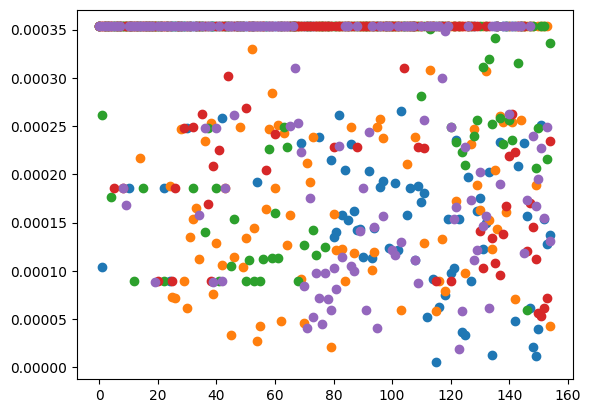

In [57]:
temp = -np.array(train_ys)[:,:,1]/10000
plt.scatter(np.arange(155),temp[0,:])
plt.scatter(np.arange(155),temp[1,:])
plt.scatter(np.arange(155),temp[2,:])
plt.scatter(np.arange(155),temp[3,:])
plt.scatter(np.arange(155),temp[4,:])



In [58]:
temp.min()

5.0093613e-06

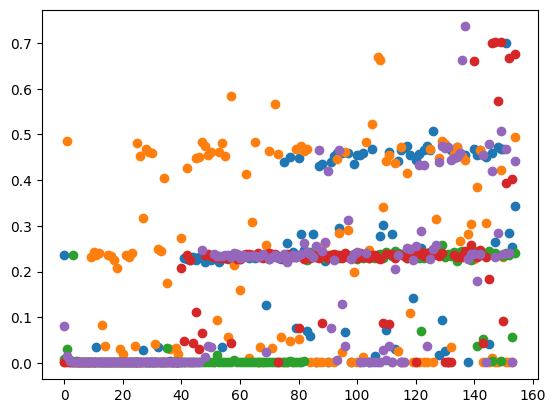

In [59]:
temp = np.array(train_ys)[:,:,0]
plt.scatter(np.arange(155),temp[0,:])
plt.scatter(np.arange(155),temp[1,:])
plt.scatter(np.arange(155),temp[2,:])
plt.scatter(np.arange(155),temp[3,:])
plt.scatter(np.arange(155),temp[4,:])

In [62]:
temp.max()*63000, 63000*0.85

(46391.27790927887, 53550.0)

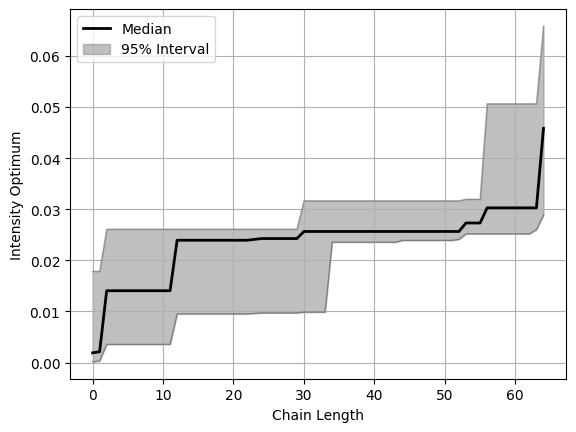

In [24]:
temp = torch.stack(train_ys)
intens = temp[:,:,0]

hist = intens.numpy()/10.0
temp = []
for i in range(4):
  y1_maxs = np.maximum.accumulate(hist[i,:])
  temp.append(y1_maxs)

t = np.stack(temp)
lower = np.quantile(t, 0.1, axis=0)
upper = np.quantile(t, 0.9, axis=0)
mid = np.quantile(t, 0.5, axis=0)
# means = np.mean(hist, axis=0)
# stds = np.std(hist, axis=0)

# lower = means - stds
# upper = means + stds

plt.plot(lower,'k',linewidth=1, alpha=0.25)
plt.plot(upper, 'k', linewidth=1, alpha=0.25)
plt.plot(mid, 'k', linewidth=2, label="Median")
plt.fill_between(np.arange(65), upper, lower, alpha=0.5, color='gray', label="95% Interval")
plt.xlabel("Chain Length")
plt.ylabel("Intensity Optimum")
plt.grid()
plt.legend()

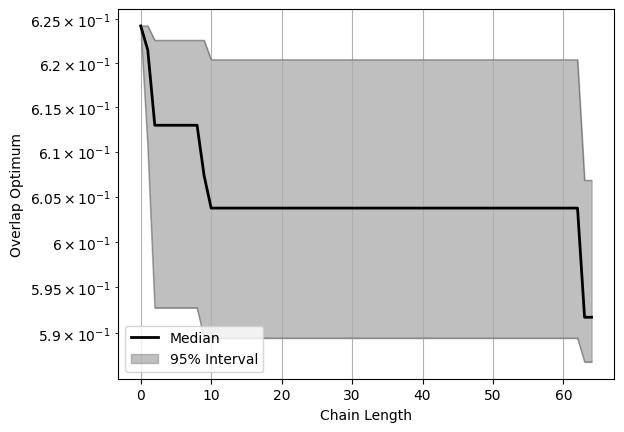

In [25]:
temp = torch.stack(train_ys)
intens = temp[:,:,1]

hist = intens.numpy()

temp = []
for i in range(4):
  y1_maxs = np.maximum.accumulate(hist[i,:])
  temp.append(y1_maxs)

t = np.stack(temp)
lower = np.quantile(t, 0.1, axis=0)
upper = np.quantile(t, 0.9, axis=0)
mid = np.quantile(t, 0.5, axis=0)
# means = np.mean(hist, axis=0)
# stds = np.std(hist, axis=0)

# lower = means - stds
# upper = means + stds
# ax1.plot(np.exp(-y2_maxs),'k')
# ax1.set_yscale('log')
l = np.exp(-lower)
u = np.exp(-upper)
medianx = np.exp(-mid)

plt.plot(l,'k',linewidth=1, alpha=0.25)
plt.plot(u, 'k', linewidth=1, alpha=0.25)
plt.plot(medianx, 'k', linewidth=2, label="Median")
plt.fill_between(np.arange(65), u, l, alpha=0.5, color='gray', label="95% Interval")
plt.yscale("log")
plt.xlabel("Chain Length")
plt.ylabel("Overlap Optimum")
plt.grid()
plt.legend()